# Chatbot Feature Engineering and Final Modeling

## Table of Contents
1. Load Packages and Data
2. Feature Engineering
    * frequent word count
    * word frequency per sentence
    * create features
    * TFIDF
3. Modeling and Performance Analysis 
4. Summary
    * conclusions
    * notebook details


In [3]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from PIL import Image
from gensim.models import KeyedVectors
#from library import *

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import string
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from spellchecker import SpellChecker

import os
import sys
# use os to get path
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))

C:\Users\Hailey\Documents\GitHub\SBwork\Capstone3-Chatbot


In [66]:
# load data
# set up paths 
data_path = os.path.join(PROJ_ROOT,'Data', 'kaggle-dialogs-and-hangouts-dialogs.txt')
data_dir = os.path.join(PROJ_ROOT, 'Data')
figure_path = os.path.join(PROJ_ROOT,'Figures')
# load cleaned data from previous analysis
df = pd.read_csv(data_path, sep=',').drop('Unnamed: 0', axis=1)
df.head(3)

,SenderText,BotText
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?


## Feature Engineering

### Frequent Word Count

In [67]:
sender_words =  df.SenderText.str.split(expand=True).stack().value_counts()
bot_words =  df.BotText.str.split(expand=True).stack().value_counts()

In [68]:
word_totals = pd.concat([sender_words, bot_words], axis = 0) # put all words in one list
word_totals = pd.DataFrame(word_totals).rename(columns={0:'word_count'}) # convert to df and name col
word_totals = word_totals.groupby(word_totals.index).sum() #group like words and sum
word_totals.sort_values(by='word_count', ascending = False, inplace = True) # sort by count

In [69]:
# summary stats
word_totals.describe()

,word_count
count,4036.000000
mean,11.880327
std,64.446651
min,1.000000
25%,2.000000
50%,2.000000
75%,6.000000
max,1939.000000


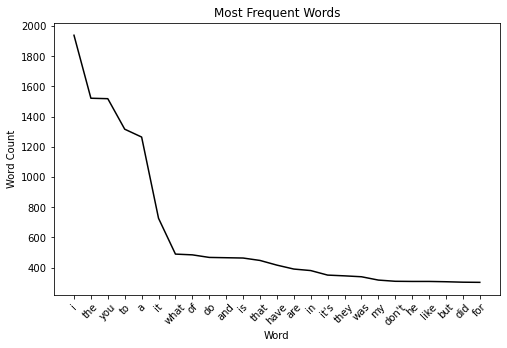

In [71]:
# Plot most frequent words
plot_title = 'most-frequent-words' # name for plot and save
plt.figure(figsize=(8,5)) # sizing
plt.title(plot_title.replace('-', ' ').title()) # plot title
plt.plot(word_totals['word_count'][:25], color='black', label='STANDARD') # plot
plt.xlabel('Word')
plt.ylabel('Word Count')
plt.xticks(rotation=45); # x-axis config
# save 
plt.savefig(figure_path+'\\'+ 'plot_title'+'.png', transparent=True)

### Occurance of Top Words Sentences

In [6]:
#from itertools import product
sentence_list = []
word_list = []
count_list = []
freq_in_sent = pd.DataFrame(columns = ['sentence', 'word', 'word_count_in_sent'])
for row in df.SenderText:
    for word in word_totals.index:
        word_list.append(word)
        count_list.append(row.count(word))
        sentence_list.append(row)

freq_in_sent.sentence = sentence_list
freq_in_sent.word = word_list
freq_in_sent.word_count_in_sent = count_list

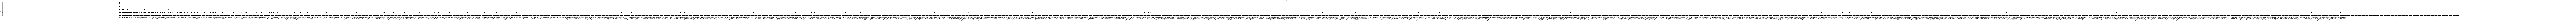

In [9]:
# plot 
plot_title = 'occurance-of-top-words-in-sentences' #set title
plt.figure(figsize=(500,5)) # set size
plt.title(plot_title.replace('-', ' ').title()) # format title from plot_title
plt.scatter(freq_in_sent['word'], freq_in_sent['word_count_in_sent'],color='black', label='STANDARD') # plot
plt.xlabel('Word') #x-label
plt.ylabel('Word Count in Sentence') #y-label
plt.xticks(rotation=45); #format x axis text
plt.tight_layout()
# save fig
plt.savefig(figure_path+'\\'+ plot_title+'.png', transparent=True) #save fig in figure path with plot_title name

From the plot above we can see that the most frequent words are not always used most frequently within one sentence.  It is sensical that a word would be used once or twice (if at all) in a sentence, although, we do see a few cases where the same word is used 4 or more times in a sentence.  

### Create Features

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

#AllText = df.SenderText.append(df.BotText).drop_duplicates()

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=list(sender_words.index))
cv_matrix = cv.fit_transform(df.SenderText)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
# collect words as feature names
words = cv.get_feature_names()
# create dataframe of cv_matrix
words_df = pd.DataFrame(cv_matrix, columns=words)
words_df.head()

,i,you,the,to,a,it,what,is,do,of,...,supermarket?,killer,picked,loosened,covered,husband?,months,butter!,cuffs?,trash
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
SenderText = pd.DataFrame(df.SenderText) 
SenderText.head()

,SenderText
0,"hi, how are you doing?"
1,i'm fine. how about yourself?
2,i'm pretty good. thanks for asking.
3,no problem. so how have you been?
4,i've been great. what about you?


In [28]:
# merge original data with new features
words_combined = SenderText.merge(words_df, left_index=True, right_index=True)
words_combined = words_combined.merge(df.BotText, left_index=True, right_index=True)
words_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Columns: 3784 entries, SenderText to BotText
dtypes: int64(3782), object(2)
memory usage: 107.5+ MB


In [29]:
# check the new df out.
#words_combined.loc[6]
words_combined.head()

,SenderText,i,you,the,to,a,it,what,is,do,...,killer,picked,loosened,covered,husband?,months,butter!,cuffs?,trash,BotText
0,"hi, how are you doing?",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i'm fine. how about yourself?
1,i'm fine. how about yourself?,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no problem. so how have you been?
3,no problem. so how have you been?,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i've been great. what about you?
4,i've been great. what about you?,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,i've been good. i'm in school right now.


### TFIDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

#AllText = df.SenderText.append(df.BotText).drop_duplicates()

tv = TfidfVectorizer(min_df=0., max_df=1., vocabulary=list(sender_words.index))
tv_matrix = tv.fit_transform(df.SenderText)
tv_matrix = tv_matrix.toarray()

In [22]:
vocab = tv.get_feature_names()
tfidf_df = pd.DataFrame(tv_matrix, columns = words)
tfidf_df.head()

,i,you,the,to,a,it,what,is,do,of,...,supermarket?,killer,picked,loosened,covered,husband?,months,butter!,cuffs?,trash
0,0.0,0.276281,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.202886,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.246727,0.0,0.0,0.0,0.0,0.343912,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
SenderText = pd.DataFrame(SenderText)
tfidf_full = SenderText.merge(tfidf_df, left_index=True, right_index=True)
tfidf_full = tfidf_full.merge(df.BotText, left_index=True, right_index=True)
tfidf_full.head()

,SenderText,i,you,the,to,a,it,what,is,do,...,killer,picked,loosened,covered,husband?,months,butter!,cuffs?,trash,BotText
0,"hi, how are you doing?",0.0,0.276281,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,i'm fine. how about yourself?
1,i'm fine. how about yourself?,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no problem. so how have you been?
3,no problem. so how have you been?,0.0,0.202886,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,i've been great. what about you?
4,i've been great. what about you?,0.0,0.246727,0.0,0.0,0.0,0.0,0.343912,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,i've been good. i'm in school right now.


In this section, we have created two sets of data with features.  The first weights the features as binary and the second weights the features.  Each set of data is correlated with the SenderText and could be utilized to predict the BotText.  

While the dataframes created with features could be used to create a communicative bot, this limited because it would require a large amount of data to train it well.  Furthermore, as the amount of data grows, the number of features would also grow.  The growth of features would quickly create a dataset that would require a very large amount of memory.  

Since there are better methods to train a bot (like the one previously created) we will work with those.  Next we will work to improve the predictive power of the initial model created during exploration in the previous notebook.

## Modeling and Performance Analysis

### Split Data
If the feature encoded data were to be utilized, the following would be done, however, in this case we will revert back to our pipeline and optimize it instead.

In [39]:
words_combined.set_index('SenderText', inplace=True)
words_combined.head()

,i,you,the,to,a,it,what,is,do,of,...,killer,picked,loosened,covered,husband?,months,butter!,cuffs?,trash,BotText
SenderText,,,,,,,,,,,,,,,,,,,,,
"hi, how are you doing?",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i'm fine. how about yourself?
i'm fine. how about yourself?,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i'm pretty good. thanks for asking.
i'm pretty good. thanks for asking.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no problem. so how have you been?
no problem. so how have you been?,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i've been great. what about you?
i've been great. what about you?,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,i've been good. i'm in school right now.


In [40]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(words_combined.iloc[:,:3782], 
                                                    words_combined.BotText, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Model
Here we will work to improve the pipeline investigated previously to attempt to make it understand more and give a reasonable response.  

In [6]:
# create functions for cleaning the text

# remove patterns from words so they can be recognized 
def reduce_length(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

# define a specialized function for the CountVectorizer analyzer
# split, remove punctuation and other sybols, lowercase
# filter stop words
def text_cleaner(text):
    tokens = word_tokenize(text) # split
    tokens = [word.lower() for word in tokens] # lowercase
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    # remove non alphanetic
    words = [word for word in stripped if word.isalpha()]
    # filter stop words
    stop_words = stopwords.words('english')
    words = [word for word in words if not word in stop_words]
    # correct spelling
    words_reduced = [reduce_length(word) for word in words]
    spell = SpellChecker()
    correct_words = [spell.correction(word) for word in words_reduced]
    return correct_words

# example of modified text_cleaner() at work
text_cleaner('I am teeeeeest!ing that the! function< is working# as *** expected and> removing stop words, as wellllll as, ?!punctuation.') 

['test',
 'ing',
 'function',
 'working',
 'expected',
 'removing',
 'stop',
 'words',
 'well',
 'punctuation']

In [107]:
# make a pipeline for classification
pipe = Pipeline([
    ('bow',CountVectorizer(analyzer=text_cleaner)), #analyzer=text_cleaner
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

pipe.fit(df.SenderText, df.BotText)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner at 0x0000001514543CA8>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

In [118]:
# testing lines the bot knows
print('Responses to lines the bot knows:')
print(pipe.predict(['Hi, how are you doing'])[0])
print(pipe.predict(["i'm pretty good. thanks for asking."])[0])
print(pipe.predict(['What did they say?'])[0])
print('\n')
# testing with lines similar to what the bot knows
print('Responses to lines similar to what the bot knows')
print(pipe.predict(['Hi, how are you today'])[0]) #single word change
print(pipe.predict(["i'm good. thanks for asking."])[0]) #single word excluded
print(pipe.predict(["hwat did they say?"])[0])  #testing a typo
print('\n')
# testing with lines unknown to the bot
print('Responses to lines unknown to the bot')
print(pipe.predict(["where is the lizard?"])[0])
print(pipe.predict(["what should we have for lunch?"])[0])
print(pipe.predict(["what's your favorite food?"])[0])

Responses to lines the bot knows:
i'm fine. how about yourself?
no problem. so how have you been?
but i'm worried about tiger.


Responses to lines similar to what the bot knows
that's a bad day.
when are they going to fix this problem?
but i'm worried about tiger.


Responses to lines unknown to the bot
a hospital is the most dangerous place in the world.
thank you.
do they talk about us?


## Summary

After attempting to improve the automated response text using a classification pipeline, it becomes very clear that this approach has severe limitations.  Despite having cleaner inputs with better spelling (achieved through text_cleaner function), the responses are farther off than the first pass.  

This indicates that we either need a much larger dataset to make our model effective or we need a better supervised learning method/technique and/or input.  For example, having data that is labeled with the conversation type would help us better understand the intent of the conversation.  This would allow for better classification because the model would then only need to choose a response from a category dictated by the user input.  

At this point, I created a rasa chatbot with samples of the text and quickly trained the model to be more versitile.  For more information on rasa and creating a chatbot with rasa, please see their [website](https://rasa.com/).

### Notebook Details

In [81]:
# use watermark in a notebook with the following call
%load_ext watermark

# %watermark? #<-- watermark documentation

%watermark -a "H.GRYK" -d -t -v -p sys
%watermark -p numpy
%watermark -p pandas
%watermark -p string
%watermark -p nltk
%watermark -p sklearn
%watermark -p tqdm
%watermark -p re
%watermark -p pattern

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
H.GRYK 2020-11-12 13:51:25 

CPython 3.7.7
IPython 7.18.1

sys 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
numpy 1.19.1
pandas 1.0.5
string unknown
nltk 3.5
sklearn 0.23.2
tqdm 4.48.2
re 2.2.1
pattern 3.6
